In [14]:

import os
import json
import requests
import operator
from typing import List
from dotenv import load_dotenv
from datetime import date, datetime
from typing import TypedDict, Annotated, Sequence
from langgraph.graph import Graph, END
from langchain_core.messages import HumanMessage
from langchain_core.messages import SystemMessage
from langchain_core.pydantic_v1 import BaseModel
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain_community.tools.openweathermap import OpenWeatherMapQueryRun
from langchain_core.utils.function_calling import convert_to_openai_function
from langchain_core.messages import BaseMessage
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate
from langgraph.prebuilt import ToolInvocation
from langchain_core.messages import FunctionMessage
from langgraph.prebuilt import ToolExecutor


load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
os.environ["OPENWEATHERMAP_API_KEY"] = os.environ.get("OPENWEATHERMAP_API_KEY")

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]




@tool
def get_joke() -> str:
    """
    Fetch a random joke from the JokeAPI.

    Returns:
        str: The fetched joke as a string. If no joke is available, returns 'No joke available'.
    """
    response = requests.get("https://v2.jokeapi.dev/joke/Any?type=single")
    joke = response.json().get('joke', 'No joke available')
    return joke


llm = ChatOpenAI(model="gpt-4o-mini", openai_api_key=OPENAI_API_KEY, temperature=0, streaming=True)
#llm = ChatGoogleGenerativeAI(model="gemini-pro", google_api_key=GOOGLE_API_KEY, temperature=0, streaming=True)
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant. "
            " Use the provided tools to search weather , and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())
tools = [
    OpenWeatherMapQueryRun(),
    #get_joke()
]
functions = [convert_to_openai_function(t) for t in tools]
model = llm.bind_functions(functions=functions)
#assitant = primary_assistant_prompt | llm.bind_tools(tools)

def function_1(state):
    messages = state['messages']
    response = model.invoke(messages)
    return {"messages": [response]}

tool_executor = ToolExecutor(tools)

def function_2(state):
    messages = state['messages']
    last_message = messages[-1]  # this has the query we need to send to the tool provided by the agent

    # Parse the tool input from the function call
    parsed_tool_input = json.loads(last_message.additional_kwargs["function_call"]["arguments"])

    # Print the parsed tool input for debugging
    print("Parsed Tool Input:", parsed_tool_input)

    # Ensure the key exists in the parsed tool input
    if 'location' in parsed_tool_input:
        tool_input_value = parsed_tool_input['location']
    else:
        raise KeyError("The key 'location' does not exist in the tool input.")

    # Construct a ToolInvocation from the function call and pass in the tool name and the expected str input for OpenWeatherMap tool
    action = ToolInvocation(
        tool=last_message.additional_kwargs["function_call"]["name"],
        tool_input=tool_input_value,
    )

    # Call the tool_executor and get back a response
    response = tool_executor.invoke(action)

    # Use the response to create a FunctionMessage
    function_message = FunctionMessage(content=str(response), name=action.tool)

    # Return a list, because this will get added to the existing list
    return {"messages": [function_message]}

def where_to_go(state):
    messages = state['messages']
    last_message = messages[-1]
    
    if "function_call" in last_message.additional_kwargs:
        return "continue"
    elif "joke" in last_message.content.lower():
        return "joke"
    else:
        return "end"

workflow = Graph()
workflow.add_node("agent", function_1)
workflow.add_node("tool", function_2)

# The conditional edge requires the following info below.
# First, we define the start node. We use `agent`.
# This means these are the edges taken after the `agent` node is called.
# Next, we pass in the function that will determine which node is called next, in our case where_to_go().

workflow.add_conditional_edges("agent", where_to_go,{   # Based on the return from where_to_go
                                                        # If return is "continue" then we call the tool node.
                                                        "continue": "tool",
                                                        # Otherwise we finish. END is a special node marking that the graph should finish.
                                                        "end": END
                                                    }
)

# We now add a normal edge from `tools` to `agent`.
# This means that if `tool` is called, then it has to call the 'agent' next. 
workflow.add_edge('tool', 'agent')


# Basically, agent node has the option to call a tool node based on a condition, 
# whereas tool node must call the agent in all cases based on this setup.

workflow.set_entry_point("agent")


app = workflow.compile()

#inputs = {"messages": [HumanMessage(content="what is the temperature of Oakland")]}
inputs = {"messages": [HumanMessage(content="Give me a info about the weather in the city that olympic 2024 is live")]}
for output in app.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'agent':
---
{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"location":"Paris,FR"}', 'name': 'open_weather_map'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a'}, id='run-b6d0e10e-43f5-4b64-ae05-11d7a835f508-0')]}

---

Parsed Tool Input: {'location': 'Paris,FR'}
Output from node 'tool':
---
{'messages': [FunctionMessage(content='In Paris,FR, the current weather is as follows:\nDetailed status: broken clouds\nWind speed: 1.54 m/s, direction: 110°\nHumidity: 83%\nTemperature: \n  - Current: 20.23°C\n  - High: 21.26°C\n  - Low: 19.1°C\n  - Feels like: 20.48°C\nRain: {}\nHeat index: None\nCloud cover: 75%', name='open_weather_map')]}

---

Output from node 'agent':
---
{'messages': [AIMessage(content='The current weather in Paris, France is as follows:\n\n- **Condition**: Broken clouds\n- **Temperature**: \n  - Current: 20.23°C\n  - High: 21.26°C\n

In [15]:
import requests
import sqlite3
import json
import pandas as pd
 
menu_code = "MENU001040"
products_db = "products.db"
def fetch_categories():
    url = f'https://ktncore.softworld.dev/api/v1/Menus/Categories?menuCode={menu_code}&page=1&pageSize=20'
    headers = {
        'accept': 'text/plain',
        'brandCode': 'KATINAT'
    }
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    data = response.json()
    return [category['id'] for category in data['result']['items']]
 
def fetch_products(category_id):
    url = 'https://ktncore.softworld.dev/api/v1/Menus/ListMenuProducts'
    headers = {
        'accept': 'text/plain',
        'Content-Type': 'application/json-patch+json'
    }
    payload = {
        "menuCode": menu_code,
        "categoryId": category_id,
        "page": 1,
        "pageSize": 20
    }
    response = requests.post(url, headers=headers, data=json.dumps(payload))
    response.raise_for_status()
    return response.json()['result']['products']['items']
 
categories = fetch_categories()
products = []
for category in categories:
    products += fetch_products(category)
 
print(products)  
 
 
def store_products(products: list[dict]):
    # Convert to DataFrame
    df = pd.json_normalize(products)
    print(df)
    # Convert list columns to JSON strings
    list_columns = ['productImages', 'attributeValues', 'productOptionValues', 'productOptions', 'productVariations']
    for col in list_columns:
        df[col] = df[col].apply(json.dumps)
 
    # Save DataFrame to SQLite
    conn = sqlite3.connect(products_db)
    df.to_sql('products', conn, if_exists='replace', index=False)
    df.to_csv("urmama.csv", index=False)
    conn.close()
    return df
 
df = store_products(products)


[{'id': 2007, 'type': 3, 'name': 'Combo Mua 1 Tặng 1 - Golden Day', 'dealNo': None, 'name_En': None, 'productSize': None, 'productSize_En': None, 'slug': 'combo-mua-1-tang-1-golden-day-2007', 'ratingCount': 0, 'ratingAverage': 0.0, 'reviewsCount': 0, 'shortDescription': None, 'shortDescription_En': None, 'description': None, 'description_En': None, 'categoryId': 1094, 'cateName': 'Combo', 'cateName_En': None, 'cateMetaTags': None, 'sku': 'testt', 'calculatedPrice': {'price': 113000.0, 'oldPrice': None, 'rootPriceWithoutTax': 104629.62962962964, 'rootPriceWithTax': 113000.0, 'vat': 8, 'priceIncVat': True}, 'rankDiscount': 0.0, 'rootPrice': 113000.0, 'displayRootPrice': '113,000₫', 'price': 113000.0, 'displayPrice': '113,000₫', 'rankDiscountAmount': 0.0, 'priceDiscountDisPlay': None, 'realPrice': 0.0, 'oldPriceDisPlay': None, 'percentOfSavingDisPlay': None, 'currency': None, 'parentId': None, 'images': '[]', 'hasOptions': False, 'thumbnailImage': None, 'promotionLink': None, 'productThum

In [16]:
def remove_unwanted_values(d):
    if isinstance(d, dict):
        return {k: remove_unwanted_values(v) for k, v in d.items() if v not in [None, "error"]}
    elif isinstance(d, list):
        return [remove_unwanted_values(i) for i in d if i not in [None, "error"]]
    else:
        return d
def remove_key(d, key_to_remove):
    if isinstance(d, dict):
        # Xóa khóa nếu có và tiếp tục xử lý các giá trị
        d.pop(key_to_remove, None)
        for k, v in list(d.items()):
            d[k] = remove_key(v, key_to_remove)
    elif isinstance(d, list):
        # Xử lý từng phần tử trong danh sách
        for i in range(len(d)):
            d[i] = remove_key(d[i], key_to_remove)
    return d

#compact_json = json.dumps(filtered_data, ensure_ascii=False, separators=(',', ':'))

#print(check)
def find_product_options(d):
    options = []
    if isinstance(d, dict):
        for k, v in d.items():
            if k == "productOptions":
                options.append(v)
            else:
                options.extend(find_product_options(v))
    elif isinstance(d, list):
        for item in d:
            options.extend(find_product_options(item))
    return options

def slug_find(slug:str):
    headers = {
    "Authorization": f"Bearer {'eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJodHRwOi8vc2NoZW1hcy54bWxzb2FwLm9yZy93cy8yMDA1LzA1L2lkZW50aXR5L2NsYWltcy9uYW1laWRlbnRpZmllciI6IjM2ODA5MyIsImh0dHA6Ly9zY2hlbWFzLnhtbHNvYXAub3JnL3dzLzIwMDUvMDUvaWRlbnRpdHkvY2xhaW1zL25hbWUiOiIwODg4ODg4ODg4IiwiQXNwTmV0LklkZW50aXR5LlNlY3VyaXR5U3RhbXAiOiJaTEk0SUtCNERVT01ISFRNUENBNUdaU1NLT1BNVUVBNiIsImh0dHA6Ly93d3cuYXNwbmV0Ym9pbGVycGxhdGUuY29tL2lkZW50aXR5L2NsYWltcy90ZW5hbnRJZCI6IjEiLCJzdWIiOiIzNjgwOTMiLCJqdGkiOiI5NWI4MTRkMC1jNTE0LTQzZGMtOTdmMC03NzExMzdiNjhjYzciLCJpYXQiOjE3MjMwOTI3MzAsIm5iZiI6MTcyMzA5MjczMCwiZXhwIjoxNzI1Njg0NzMwLCJpc3MiOiJTV09PRCIsImF1ZCI6IlNXT09EIn0.D_3iMv4L06HCZnXMHmevjsvBcrhPGJnIuWXjJat5BZs'}"}
    response = requests.get("https://ktncore.softworld.dev/api/v2/ProductMenu/GetBySlug?slug="+slug, headers=headers)
    check = response.json()
# Lấy tất cả các phần tử có khóa "productOptions"
    product_options = find_product_options(check)
    product_options = remove_unwanted_values(product_options)
    product_options = remove_key(product_options, "isActive")
    product_options = remove_key(product_options, "price")
    product_options = remove_key(product_options, "code")
    product_options = remove_key(product_options, "uomid")
    product_options = remove_key(product_options, "sku")
    product_options = remove_key(product_options, "value")
    product_options = remove_key(product_options, "productId")
    product_options = remove_key(product_options, "displayOrder")
    product_options = remove_key(product_options, "optionId")
    product_options = remove_key(product_options, "Name_En")
    product_options = remove_key(product_options, "quantity")
    return json.dumps(product_options, ensure_ascii=False, indent=4, separators=(',', ':')).replace("\n", "").replace(" ", "")


In [17]:

import os
import json
import requests
import operator

from typing import List
from dotenv import load_dotenv
from datetime import date, datetime
from typing import TypedDict, Annotated, Sequence
from langgraph.graph import Graph, END
from langchain_core.messages import HumanMessage
from langchain_core.messages import SystemMessage
from langchain_core.pydantic_v1 import BaseModel
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain_community.tools.openweathermap import OpenWeatherMapQueryRun
from langchain_core.utils.function_calling import convert_to_openai_function
from langchain_core.messages import BaseMessage
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate
from langgraph.prebuilt import ToolInvocation
from langchain_core.messages import FunctionMessage
from langgraph.prebuilt import ToolExecutor




load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
os.environ["OPENWEATHERMAP_API_KEY"] = os.environ.get("OPENWEATHERMAP_API_KEY")
weather = OpenWeatherMapAPIWrapper()

@tool
def get_joke(joke: str) -> str:
    '''Return the joke.
    '''
    response = requests.get("https://v2.jokeapi.dev/joke/Any?type=single")
    joke = response.json().get('joke', 'No joke available')
    return f"{joke}"


def find_product_options(d):
    options = []
    if isinstance(d, dict):
        for k, v in d.items():
            if k == "productOptions":
                options.append(v)
            else:
                options.extend(find_product_options(v))
    elif isinstance(d, list):
        for item in d:
            options.extend(find_product_options(item))
    return options
def remove_unwanted_values(d):
    if isinstance(d, dict):
        return {k: remove_unwanted_values(v) for k, v in d.items() if v not in [None, "error"]}
    elif isinstance(d, list):
        return [remove_unwanted_values(i) for i in d if i not in [None, "error"]]
    else:
        return d
def remove_key(d, key_to_remove):
    if isinstance(d, dict):
        # Xóa khóa nếu có và tiếp tục xử lý các giá trị
        d.pop(key_to_remove, None)
        for k, v in list(d.items()):
            d[k] = remove_key(v, key_to_remove)
    elif isinstance(d, list):
        # Xử lý từng phần tử trong danh sách
        for i in range(len(d)):
            d[i] = remove_key(d[i], key_to_remove)
    return d

@tool
def choose_sub_product(slug: str) -> str:
    """
    Process product options for an order.

    Args:
        slug (str): The slug for the product.

    Returns:
        str: A message indicating the status of the product option processing.
    """
    # Fetch the product data from the API
    response = requests.get(f"https://ktncore.softworld.dev/api/v2/ProductMenu/GetBySlug?slug={slug}")
    check = response.json()
    
    # Extract product options
    product_options = find_product_options(remove_unwanted_values(check))
    
    # Remove unwanted keys
    keys_to_remove = ["isActive", "price", "code", "uomid", "sku", "productId", "displayOrder", "optionId", "Name_En", "quantity", "uomId"]
    for key in keys_to_remove:
        product_options = remove_key(product_options, key)
    
    # Convert to JSON and format it
    formatted_options = json.dumps(product_options, ensure_ascii=False, indent=4, separators=(',', ':')).replace("\n", "").replace(" ", "")
    
    # Process each option
    """    result_messages = []
    for product_option in product_options:
        option_details = product_option.get("option", {})
        option_name = option_details.get("name_En", "Unknown Option")
        is_option_note = option_details.get("isOptionNote", False)

        # Check if the option requires user input
        if is_option_note and not option_details.get("note"):
            result_messages.append(f"Option '{option_name}' requires additional input.")
            continue
        
        # Process each value within the option
        values = product_option.get("values", [])
        if not values:
            result_messages.append(f"Option '{option_name}' has no available values.")
            continue

        processed_values = []
        for value in values:
            value_name = value.get("value_En", "Unknown Value")
            display_price = value.get("displayPrice", "Unknown Price")
            processed_values.append(f"{value_name}: {display_price}")

        # Format the output message for the option
        result_messages.append(f"Option '{option_name}' processed with values: {', '.join(processed_values)}")
    
    # Check if all required options are filled
    required_options = [option for option in product_options if option.get("option", {}).get("isRequired", False) and not option.get("option", {}).get("note")]
    if required_options:
        result_messages.append("Order failed: Some required options are missing information.")"""
   
    #return "\n".join(result_messages)
    return formatted_options
    
@tool
def confirm_answer_subproduct(answer_id: str, name_sub_product: str) -> str:
    ''' Confirm the answer of sub product
    '''
    with open("output.txt", "a", encoding="utf-8") as file:
    # Write the additional content to the file
        file.write(answer_id + name_sub_product + "\n")  # Adding a newline for separation
    return  answer_id + " show not choose part of the subproduct"


@tool
def order_product(product_id: int, quantity=1) -> str:
    """
    Order Product by its ID.
 
    Args:
        product_id (int): The ID of the product to order.
        quantity (int): The quantity of the product to order. Defaults to 1.
    Returns:
        str: A message indicating whether the hotel was successfully order or not.
    """
    config = ensure_config()
    configuration = config.get("configurable", {})
    # Check if all required information is present in the configuration
    recipient_name = order_information.get("recipient_name", None)
    phone_number = order_information.get("phone_number", None)
    address = order_information.get("address", None)
    delivery_time = order_information.get("delivery_time", None)
    if not recipient_name or not phone_number or not address:
        return "Order failed: Missing recipient name, phone number, or address."
 
    conn = sqlite3.connect(products_db)
    cursor = conn.cursor()
 
    product = cursor.execute(
        "SELECT * FROM products WHERE id = ?", (product_id,)
    ).fetchone()
    conn.close()
 
    if product:
        print(product)
        product_name = product[2]
        message = f"""
    Product {quantity} x {product_name} successfully order.
    Receiptent Name: {recipient_name}
    Phone Number: {phone_number}
    Address: {address}
    Delivery Time: {delivery_time}
    """
        order_information = {
            **order_information,
            "delivery_time": None,
        }
        return message
    else:
        return f"No product found with ID {product_id}."
@tool
def check_weather(location: str): #-> float:
    '''Return the weather forecast for the specified location.'''
    weather_data = weather.run(location)
    print(location ," is the city")
    return f"{weather_data} + in {location}"

@tool
def check_item(item: str) -> float:
    '''Return the name of that item.'''
    return f"The item we talkabout is {item}"

@tool
def show_menu(item: str) -> float:
    '''Return the menu list'''
    return f"The menu is  {df["slug"]}"

@tool
def check_metting_day(check_in_date: str, check_out_date: str) -> float:
    '''Return the check in date and check out date'''
    return f"{check_in_date} is the check in date and {check_out_date} is the check out date"

not_safe_tools = [confirm_answer_subproduct, check_weather] #order_product
safe_tools = [check_metting_day, get_joke,show_menu,choose_sub_product]
model = ChatOpenAI(model="gpt-4o-mini", openai_api_key=OPENAI_API_KEY, temperature=0, streaming=True)
sensitive_tool_names = {t.name for t in not_safe_tools}
#model = model.bind_tools(tools)
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support. "
            "Use the provided tools and other information to assist the user's queries. "
            "When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If a search comes up empty, expand your search before giving up."
        ),
        ("placeholder", "{messages}"),
    ]
)

# Cung cấp giá trị cho tham số time bằng cách sử dụng .partial()
primary_assistant_prompt = primary_assistant_prompt.partial(time=datetime.now().isoformat())

# Kiểm tra kết quả



In [18]:

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from langgraph.graph.message import AnyMessage, add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}
#tools = [check_weather, check_live_traffic, check_tennis_score]

model = ChatOpenAI(model="gpt-4o-mini", openai_api_key=OPENAI_API_KEY, temperature=0, streaming=True)

#model = model.bind_tools(tools)
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support. "
            "Use the provided tools and other information to assist the user's queries. "
            "When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If a search comes up empty, expand your search before giving up."
        ),
        ("placeholder", "{messages}"),
    ]
)

# Cung cấp giá trị cho tham số time bằng cách sử dụng .partial()
primary_assistant_prompt = primary_assistant_prompt.partial(time=datetime.now().isoformat())

# Kiểm tra kết quả
"""print(primary_assistant_prompt)
part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)"""
result = primary_assistant_prompt | model.bind_tools(not_safe_tools + safe_tools)


In [19]:

from typing import Literal
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda
from langgraph.checkpoint.memory import MemorySaver

from langgraph.prebuilt import ToolNode
def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }
def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )
builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(result))
builder.add_edge(START, "assistant")    
builder.add_node("not_safe_tools", create_tool_node_with_fallback(not_safe_tools))
builder.add_node(
    "safe_tools", create_tool_node_with_fallback(safe_tools)
)

def route_tools(state: State) -> Literal["safe_tools", "not_safe_tools", "__end__"]:
    next_node = tools_condition(state)
    # If no tools are invoked, return to the user
    if next_node == END:
        return END
    ai_message = state["messages"][-1]
    # This assumes single tool calls. To handle parallel tool calling, you'd want to
    # use an ANY condition
    first_tool_call = ai_message.tool_calls[0]
    if first_tool_call["name"] in not_safe_tools:
        return "not_safe_tools"
    return "safe_tools"
# Define edges: these determine how the control flow moves

builder.add_conditional_edges(
    "assistant",
    route_tools,
)


builder.add_edge("safe_tools", "assistant")
builder.add_edge("not_safe_tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
part_3_graph = builder.compile(
    checkpointer=memory,
    # NEW: The graph will always halt before executing the "tools" node.
    # The user can approve or reject (or even alter the request) before
    # the assistant continues
    interrupt_before=["not_safe_tools"],)

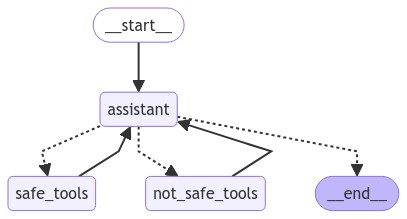

In [20]:
from IPython.display import Image, display

try:
    display(Image(part_3_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [21]:
import shutil
import uuid
def _print_event(event: dict, _printed: set):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            print(msg_repr)
            _printed.add(message.id)
#shutil.copy(backup_file, db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}
_printed = set()
"""for question in tutorial_questions:
    events = part_1_graph.stream(
        {"messages": ("user", question)}, config,  stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)"""

"""events = part_1_graph.stream(
        {"messages": ("user", "i wanna metting in 8/7 and end in 9/7 ")}, config,  stream_mode="values")
for event in events:
        _print_event(event, _printed)"""

'events = part_1_graph.stream(\n        {"messages": ("user", "i wanna metting in 8/7 and end in 9/7 ")}, config,  stream_mode="values")\nfor event in events:\n        _print_event(event, _printed)'

In [22]:
from collections import deque
while True:
    user = input("User (q/Q to quit): ")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    output = None
    for output in part_3_graph.stream({"messages": ("user", user)}, config=config, stream_mode="values"):
        _print_event(output, _printed)
        #last_message.pretty_print()
    snapshot = part_3_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        user_input = input(
            "Do you approve of the above actions? Type 'y' to continue;"
            " otherwise, explain your requested changed.\n\n"
        )
        if user_input.strip() == "y":
            # Just continue
            result = part_3_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = part_3_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=output["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_3_graph.get_state(config)

    if output and "prompt" in output:
        print("Done!")

================================ Human Message =================================

Give me Hue temperature
================================== Ai Message ==================================
Tool Calls:
  check_weather (call_C3tzdkIVZthvE2UIaHo3KRSD)
 Call ID: call_C3tzdkIVZthvE2UIaHo3KRSD
  Args:
    location: Hue
================================= Tool Message =================================
Name: check_weather

Error: check_weather is not a valid tool, try one of [check_metting_day, get_joke, show_menu, choose_sub_product].
================================== Ai Message ==================================
Tool Calls:
  check_weather (call_AsdURVGl7zUNeIVC16XX9rU4)
 Call ID: call_AsdURVGl7zUNeIVC16XX9rU4
  Args:
    location: Hue, Vietnam
================================= Tool Message =================================
Name: check_weather

Error: check_weather is not a valid tool, try one of [check_metting_day, get_joke, show_menu, choose_sub_product].
================================== Ai

In [23]:
a = choose_sub_product("me-pho-mai-s--1853") #me-pho-mai-s--1853 tra-oolong-me-dua-1879

a

'[[{"option":{"name":"Chọnmứcđá","name_En":"Chọnmứcđá","isMulti":false,"isRequired":false,"note":"Tốiđa1loại","list":[],"isOptionNote":true,"id":6},"values":[{"value":"Đábìnhthường","value_En":"null","displayPrice":"0₫","id":2166},{"value":"Ítđá","value_En":"null","displayPrice":"0₫","id":2167},{"value":"Đáriêng","value_En":"null","displayPrice":"0₫","id":2168},{"value":"Khôngđá","value_En":"null","displayPrice":"0₫","id":2169}]},{"option":{"name":"Chọnmứcđường","name_En":"Chọnmứcđường","isMulti":false,"isRequired":true,"note":"Tốiđa1loại","list":[],"isOptionNote":true,"id":7},"values":[{"value":"Đườngbìnhthường","value_En":"Đườngbìnhthường","displayPrice":"0₫","id":2170},{"value":"70%đường","value_En":"70%đường","displayPrice":"0₫","id":2171},{"value":"50%đường","value_En":"50%đường","displayPrice":"0₫","id":2172},{"value":"0%đường","value_En":"0%đường","displayPrice":"0₫","id":2173}]}],[{"option":{"name":"Chọnmứcđường","name_En":"Chọnmứcđường","isMulti":false,"isRequired":true,"note"

In [24]:
response = requests.get(f"https://ktncore.softworld.dev/api/v2/ProductMenu/GetBySlug?slug={"tra-oolong-me-dua-1879"}")
check = response.json()
    
# Extract product options
product_options = find_product_options(check)
product_options   
# Remove unwanted keys


[[],
 [{'option': {'name': 'Chọn mức đá',
    'name_En': 'Chọn mức đá',
    'code': 'icelevel',
    'isMulti': False,
    'isRequired': False,
    'displayOrder': 18,
    'note': 'Tối đa 1 loại',
    'list': [],
    'isOptionNote': True,
    'id': 6},
   'values': [{'productId': 1880,
     'optionId': 6,
     'value': 'Đá bình thường',
     'value_En': 'null',
     'sku': 'icetest1',
     'uomId': 'icetest1',
     'code': 'icetest1',
     'price': 0.0,
     'quantity': 1,
     'isActive': True,
     'displayPrice': '0₫',
     'displayOrder': 1,
     'imageUrl': None,
     'imageSelectUrl': None,
     'id': 2328},
    {'productId': 1880,
     'optionId': 6,
     'value': 'Ít đá',
     'value_En': 'null',
     'sku': 'icetest2',
     'uomId': 'icetest2',
     'code': 'icetest2',
     'price': 0.0,
     'quantity': 2,
     'isActive': True,
     'displayPrice': '0₫',
     'displayOrder': 2,
     'imageUrl': None,
     'imageSelectUrl': None,
     'id': 2329},
    {'productId': 1880,
     